# <font color="#FF1493">Welcome to my XYZ Data Analysis!</font>

According to the task, the problem is users are getting into the site and leaving without watching any video, while the company is spending a lot of money to acquire users who dont generate revenue.

 <p style="text-decoration: underline;">We would like to:</p>
<ol>
  <li>
      Assign each video to one of three categories: Top, Good, or Else (lowest likelihood).
  </li>
    <li>
        Identify the most important characteristics that determine which videos are counted as "Top" videos.
    </li>
    
</ol>

 <p style="text-decoration: underline;">My assumptions are:</p>
<ol>
  <li>
      As described in the task, we are a company like YouTube that makes money from advertising. <br> YouTube automatically displays ads when you enter a video, so the most viewed videos are the most profitable.
  </li>
    <li>
        Because we don't know if a client left the video in the middle, I assume that every view count means that the user watched the entire video (so every view = user that watched an ad). 
    </li>
    
</ol>


# Import Liabaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandasql
from kmodes.kprototypes import KPrototypes
import umap.umap_ as umap
import sklearn
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Importing Datasets from local host

In [2]:
df_count = pd.read_csv(r'/Users/danielevko/Library/CloudStorage/OneDrive-Personal/Documents/קורות חיים/Playstudios/home assigment/Data/video_count.csv')

In [3]:
df_feat = pd.read_csv(r'/Users/danielevko/Library/CloudStorage/OneDrive-Personal/Documents/קורות חיים/Playstudios/home assigment/Data/video_features.csv')

# Explore the video_count file

Let's check some general info.

In [4]:
df_count.head()

,video_id,date,count
0,56,2017-12-23,33
1,96,2017-12-15,58
2,100,2017-12-04,114
3,32,2017-12-25,18
4,79,2017-10-17,46


In [5]:
df_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11903 entries, 0 to 11902
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   video_id  11903 non-null  int64 
 1   date      11903 non-null  object
 2   count     11903 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 279.1+ KB


To extract info like most-watched day, month, and etc., we need to convert the date column to DateTime type.

In [6]:
df_count['date'] = pd.to_datetime(df_count['date'],format = '%Y-%m-%d')

We can see that the average view of the videos each day is 75.42 and the median view is 72. <br>
Standard Deviation, however, is almost 50% of the average, indicating a wider variation in views for each day. 

In [7]:
df_count.describe(include = 'all', datetime_is_numeric=True)

,video_id,date,count
count,11903.000000,11903,11903.000000
mean,50.494245,2017-11-30 02:24:12.339746304,75.427623
min,1.000000,2017-09-03 00:00:00,6.000000
25%,25.000000,2017-10-31 00:00:00,51.000000
50%,50.000000,2017-11-30 00:00:00,72.000000
75%,76.000000,2017-12-30 00:00:00,97.000000
max,100.000000,2018-02-27 00:00:00,196.000000
std,28.875755,NaN,33.011251


In between the first video and the last video views, there is a 177-day gap (half a year).
<a id='min_and_max_date'></a>

In [8]:
print("Between the first video and the last video, " + str((df_count['date'].max() - df_count['date'].min()).days) + " has passed")
print("The minimum date is {}".format(df_count['date'].min().date()))
print("The maximum date is {}".format(df_count['date'].max().date()))

Between the first video and the last video, 177 has passed
The minimum date is 2017-09-03
The maximum date is 2018-02-27


There are no missing values (which is good, since we won't have to fill in the missing values).

In [9]:
df_count.isnull().any()

video_id    False
date        False
count       False
dtype: bool

In general we have info on 100 diffrent videos

In [10]:
len(df_count.video_id.unique())

100

### Lets check if the month or day affects views.

The weekdays and months will need to be categorized.

In [11]:
df_count['day_name'] = df_count['date'].dt.day_name()
df_count['month'] = df_count['date'].dt.month_name()

In [12]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
df_count['day_name'] = pd.Categorical(df_count['day_name'], categories=weekdays)

[Previously](#min_and_max_date), we checked that our minimum and maximum dates are 6 months apart, so we will categorize our months based on that.

In [13]:
df_count['month'].unique()

array(['December', 'October', 'November', 'September', 'January',
       'February'], dtype=object)

In [14]:
months = ["September","October", "November", "December", "January", "February"]
df_count['month'] = pd.Categorical(df_count['month'], categories=months)

### Now let's take a look at the months and weeks versus views.
#### We will start with the months.

We can see a significant difference between the month's total views, as November was the highest and Febuary is the lowest.

Having the lowest number of views in February is bad news for XYZ since the company has seen a huge drop in views.

In [15]:
total_month_count = df_count.groupby(by='month',as_index=False).sum()
total_month_count[['month','count']]

,month,count
0,September,66209
1,October,216351
2,November,236690
3,December,212224
4,January,134659
5,February,31682


<AxesSubplot:xlabel='month', ylabel='count'>

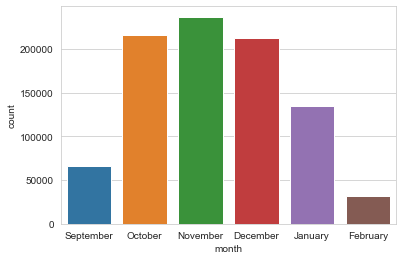

In [16]:
sns.set_style("whitegrid")
sns.barplot(x='month', y='count',data=total_month_count,estimator=sum)

Even though September had one of the fewest total views, it had the highest median,<br> which means that people were watching videos every day in September, but there aren't many rows of that month.

<AxesSubplot:xlabel='month', ylabel='count'>

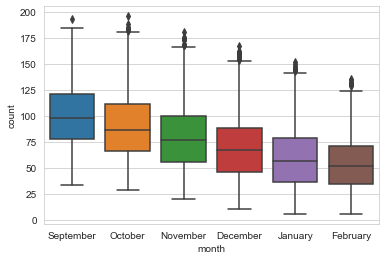

In [17]:
sns.boxplot(x="month", y="count",data = df_count)

We can verify this by looking at the percentage of the months in the dataset (September only makes up 5 percent).

In [18]:
df_count['month'].value_counts()/len(df_count)

December     0.256910
November     0.248005
October      0.200286
January      0.191212
September    0.055028
February     0.048559
Name: month, dtype: float64

### Our next step is to examine the day of the week.

As we can see, all the days of the week are distributed equally.

In [19]:
pandasql.sqldf("select day_name,sum(count) as total_views_count " +
                       "from df_count " +
                       "group by day_name " +
                       "order by sum(count) desc")

,day_name,total_views_count
0,Wednesday,129767
1,Tuesday,128633
2,Saturday,128631
3,Sunday,128405
4,Monday,128209
5,Friday,127744
6,Thursday,126426


<AxesSubplot:xlabel='day_name', ylabel='count'>

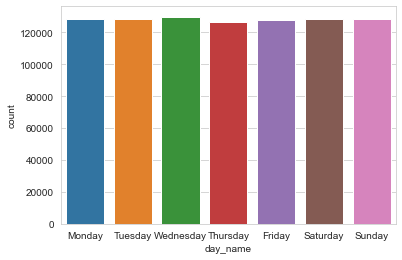

In [20]:
sns.barplot(x = 'day_name',y='count', data = df_count,estimator=sum,ci="sd")

<AxesSubplot:xlabel='day_name', ylabel='count'>

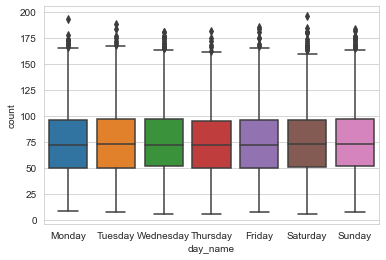

In [21]:
sns.boxplot(x="day_name", y="count",data = df_count)

Due to the fact that it does not have a significant impact on video views, it can be deleted.

In [22]:
df_count.drop(columns='day_name',axis=1,inplace=True)

The overall distribution of the count column through time shows a lot of variation and a decrease.

<AxesSubplot:xlabel='date'>

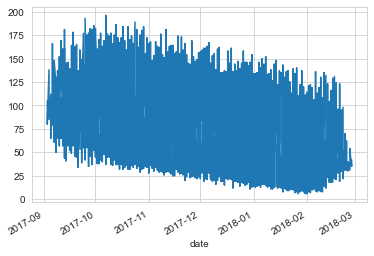

In [23]:
df_count.set_index('date').sort_index()['count'].plot()

## Explore the video_feature file

In [24]:
df_feat.head()

,video_id,video_length,video_language,video_upload_date,video_quality
0,1,16,chineese,2017-09-11,480p
1,2,27,spanish,2017-10-03,480p
2,3,30,spanish,2017-10-06,240p
3,4,15,spanish,2017-10-12,720p
4,5,19,chineese,2017-09-14,720p


In [25]:
df_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   video_id           100 non-null    int64 
 1   video_length       100 non-null    int64 
 2   video_language     100 non-null    object
 3   video_upload_date  100 non-null    object
 4   video_quality      100 non-null    object
dtypes: int64(2), object(3)
memory usage: 4.0+ KB


To extract info on video_upload_date, we need to convert the column to DateTime type.

In [26]:
df_feat['video_upload_date'] = pd.to_datetime(df_feat['video_upload_date'],format = '%Y-%m-%d')

We can see by using Describe on the dataset some important conclusions:
<ol>
  <li>
      We have information on all the 100 videos.
  </li>
  <li>
     A video's median and average length are almost equal at 23 minutes and 22.7 minutes, respectively, with 15 minutes being the minimum and 30 minutes being the maximum.
    </li>
    <li>
        In total, there are three unique languages: Chineese, Spanish, and English, with Chinese being the most common.
    </li>
    <li>
        On 2017-09-03, the first video was uploaded, and on 2017-10-30, the last one. In other words, the company uploaded videos only during those two months.
    </li>
    <li>
        There are five different video quality options, with 480p being the most common. 
    </li>
    
</ol>

In [27]:
df_feat.describe(include='all',datetime_is_numeric=True)

,video_id,video_length,video_language,video_upload_date,video_quality
count,100.000000,100.000000,100,100,100
unique,NaN,NaN,3,NaN,5
top,NaN,NaN,chineese,NaN,480p
freq,NaN,NaN,35,NaN,28
mean,50.500000,22.700000,NaN,2017-10-01 00:57:36,NaN
min,1.000000,15.000000,NaN,2017-09-03 00:00:00,NaN
25%,25.750000,19.000000,NaN,2017-09-17 00:00:00,NaN
50%,50.500000,23.000000,NaN,2017-09-29 12:00:00,NaN
75%,75.250000,27.000000,NaN,2017-10-13 00:00:00,NaN
max,100.000000,30.000000,NaN,2017-10-30 00:00:00,NaN


We don't have any missing values.

In [28]:
df_feat.isnull().any()

video_id             False
video_length         False
video_language       False
video_upload_date    False
video_quality        False
dtype: bool

## Data Merge

In order to continue with the data analysis, we will need to create one main table with all the information, which we will merge according to the video_id.

In [29]:
df = df_count.merge(df_feat, on='video_id')
df.head()

,video_id,date,count,month,video_length,video_language,video_upload_date,video_quality
0,56,2017-12-23,33,December,27,chineese,2017-10-01,480p
1,56,2017-10-28,81,October,27,chineese,2017-10-01,480p
2,56,2017-12-29,43,December,27,chineese,2017-10-01,480p
3,56,2017-10-27,60,October,27,chineese,2017-10-01,480p
4,56,2017-11-05,79,November,27,chineese,2017-10-01,480p


## Data Transformation

In order to get more information about the videos, let's perform data transformation.
<br>Let's add the total number of views for each video.

In [30]:
total_video_id_count = pandasql.sqldf("select video_id, sum(count) as total_views " +
                       "from df_count " +
                       "group by video_id " +
                       "order by sum(count) desc")
total_video_id_count.head()

,video_id,total_views
0,57,15909
1,44,14409
2,82,14328
3,52,14225
4,4,14192


Firstly, we conclude that video length, view count, and total views are negatively correlated! <br>In other words, the longer the video, the less likely people are to watch it.

In [31]:
df = df.merge(total_video_id_count, on='video_id')
df.corr()

,video_id,count,video_length,total_views
video_id,1.000000,0.025763,-0.015629,0.030729
count,0.025763,1.000000,-0.737882,0.781747
video_length,-0.015629,-0.737882,1.000000,-0.942053
total_views,0.030729,0.781747,-0.942053,1.000000


### Now lets check the effect of the quality of the video.

In [32]:
total_videos = pandasql.sqldf("SELECT * FROM df GROUP BY video_id ORDER BY total_views DESC")

The most-watched quality from all the videos is 480p, followed by 360p, 720p, 1080p, and 240p.

<AxesSubplot:xlabel='video_quality', ylabel='total_views'>

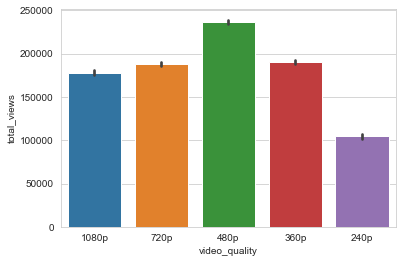

In [33]:
sns.barplot(x='video_quality',y='total_views',data=total_videos,estimator=sum,ci="sd")

According to the top 25 most-watched videos, the best quality videos are the most popular.

<AxesSubplot:xlabel='video_quality', ylabel='total_views'>

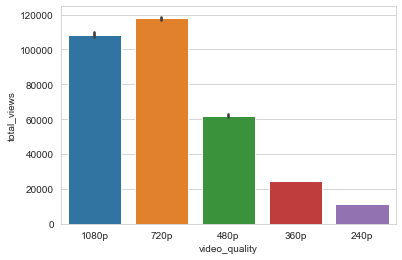

In [34]:
sns.barplot(x='video_quality',y='total_views',data=total_videos[0:25],estimator=sum,ci='sd')

We see the gap because there are fewer high-quality videos in the website.
<br> Thus, even though there are fewer data points, the most-watched ones are of higher quality.

In [35]:
df['video_quality'].value_counts()/len(df)

480p     0.280854
360p     0.229606
720p     0.169537
1080p    0.160044
240p     0.159960
Name: video_quality, dtype: float64

Contrary to this, the first quartile of total video views shows less quality.

<AxesSubplot:xlabel='video_quality', ylabel='total_views'>

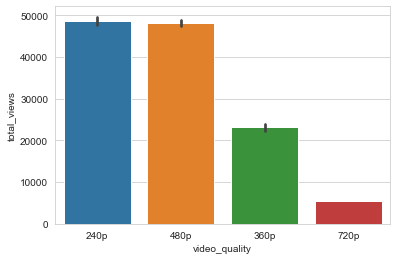

In [36]:
sns.barplot(x='video_quality',y='total_views',data=total_videos[75:],estimator=sum,ci='sd')

In [37]:
df.loc[:,df.columns!='total_views'].groupby('video_quality').mean()

,video_id,count,video_length
video_quality,,,
1080p,57.100787,93.531234,22.426247
240p,59.151786,54.817752,24.888130
360p,46.023052,69.773509,22.688986
480p,45.230332,70.723003,23.150464
720p,50.864718,93.234390,20.184836


In [38]:
total_videos.groupby('video_quality').mean()['total_views']

video_quality
1080p    11136.062500
240p      6523.312500
360p      8290.913043
480p      8443.821429
720p     11067.470588
Name: total_views, dtype: float64

Based on the results, <b>we can conclude</b> that the higher the quality of the video, the more likely people are to watch it.

### Let's examine the effect of language on views.

In [39]:
df.sort_values('date',inplace=True)

At first glance, this seems to be no difference between the languages.

<AxesSubplot:xlabel='video_language', ylabel='total_views'>

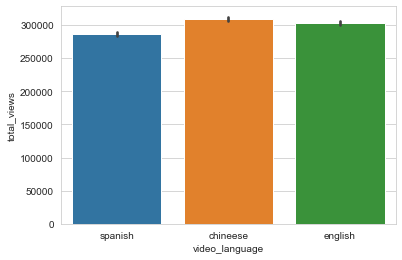

In [40]:
sns.barplot(x='video_language',y='total_views',data=total_videos,estimator=sum,ci="sd")

According to the top 25 most viewed videos, however, there is a difference and English takes the top spot, followed by Chinese, and finally Spanish.

<AxesSubplot:xlabel='video_language', ylabel='total_views'>

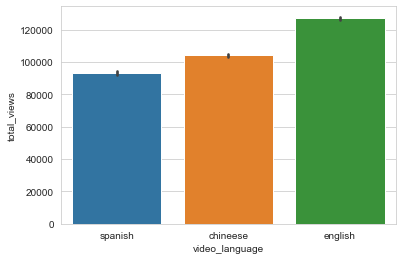

In [41]:
sns.barplot(x='video_language',y='total_views',data=total_videos[0:25],estimator=sum,ci="sd")

Comparatively, we see the same positions of the video languages in the less viewed videos.

<AxesSubplot:xlabel='video_language', ylabel='total_views'>

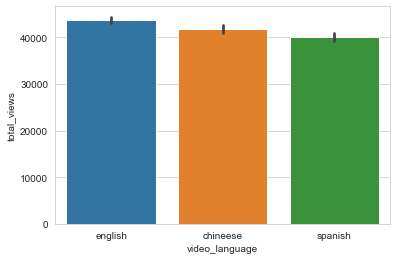

In [42]:
sns.barplot(x='video_language',y='total_views',data=total_videos[75:],estimator=sum,ci="sd")

In [43]:
total_videos['video_language'].value_counts()

chineese    35
english     33
spanish     32
Name: video_language, dtype: int64

The conclusion is that there is no difference between total views of videos by language, so it has to be examined from another perspective. <br>

Comparing the overall average with the recent average of the video languages, we can see there is a difference, with Spanish taking the top spot. <br>
As a result, seasonality is a factor in the data, and to find out if the language affects the total number of views, we need to examine how the data was distributed over time.

In [44]:
df.loc[:,df.columns != 'total_views'].groupby('video_language').mean()

,video_id,count,video_length
video_language,,,
chineese,49.230751,74.166947,22.840969
english,47.414609,77.100534,22.401629
spanish,55.058607,75.081472,22.865440


In [45]:
df.loc[:,df.columns != 'total_views'].sort_values('date')[df.sort_values('date')['date']>='2018-02-01'].groupby('video_language').mean()

,video_id,count,video_length
video_language,,,
chineese,56.062500,55.625000,22.485577
english,39.455556,46.583333,24.400000
spanish,49.857895,61.721053,22.121053


### Analyzing the data over periods of weeks

In [46]:
df_temp = df.copy()
df_temp['video_rows_count'] = df_temp['video_id']
df_temp.rename(columns={'video_id':'video_id_count'},inplace=True)
df_temp = df_temp.loc[:,df_temp.columns != 'total_views']

#### What we can see in the following table?
We can see how the data changed over the weeks in the following table:

video_id_count - Unique count videos <br>
video_rows_count - Number of rows of data in that week<br>
count - The total number of views for the week<br>
video_length - The average length of a video<br>
video_quality - The most frequent video qualities<br>
video_language - The most frequent video languages<br>
mean_views_for_video - The average total views for unique videos (by dividing the count by the video_id_count column). <br>
mean_views_for_video_pct_change - Change in percentage of mean_views_for_video

In [47]:
df_group_by_year_week = df_temp.groupby([df_temp['date'].dt.isocalendar().year,df_temp['date'].dt.isocalendar().week]).agg(
    {
        
        'video_id_count':lambda x: len(x.value_counts().index.unique()),
        'video_rows_count':'count',
        'count': 'sum',
        'video_length': 'mean',
        'video_quality':lambda x: x.value_counts().index[0:3],
        'video_language':lambda x: x.value_counts().index[0:2]
        
    }
)
df_group_by_year_week['mean_views_for_video'] = df_group_by_year_week['count'] / df_group_by_year_week['video_id_count']
df_group_by_year_week['mean_views_for_video_pct_change'] = df_group_by_year_week['mean_views_for_video'].pct_change()
df_group_by_year_week

video_id_count  video_rows_count  count  video_length  \
year week                                                          
2017 35                 3                 3    285     20.333333   
     36                10                38   3934     21.815789   
     37                26               127  12690     21.771654   
     38                38               222  22525     21.797297   
     39                52               317  31835     22.104101   
     40                64               401  37431     22.416459   
     41                79               507  47457     22.623274   
     42                88               575  50930     22.685217   
     43                98               655  58639     22.638168   
     44               100               685  58724     22.670073   
     45               100               682  55615     22.760997   
     46               100               691  55716     22.746744   
     47               100               693  54228     22.721501   
     48               100               688  50622     22.718023   
     49               100               692  49943     22.715318   
     50               100               688  48515     22.664244   
     51               100               693  47323     22.704185   
     52               100               692  45062     22.689306   
2018 1                100               664  41963     22.759036   
     2                 92               587  35322     22.889267   
     3                 77               495  28257     23.101010   
     4                 63               386  21318     23.139896   
     5                 49               313  17046     23.047923   
     6                 39               213  11502     22.976526   
     7                 22               133   7724     22.887218   
     8                 15                58   2995     22.948276   
     9                  3                 5    214     24.000000   

                 video_quality       video_language  mean_views_for_video  \
year week                                                                   
2017 35           [480p, 720p]  [english, chineese]             95.000000   
     36     [480p, 720p, 240p]   [english, spanish]            393.400000   
     37    [480p, 360p, 1080p]   [spanish, english]            488.076923   
     38    [480p, 1080p, 360p]  [spanish, chineese]            592.763158   
     39    [480p, 1080p, 360p]  [chineese, english]            612.211538   
     40    [480p, 360p, 1080p]  [english, chineese]            584.859375   
     41     [480p, 360p, 240p]  [chineese, english]            600.721519   
     42     [480p, 360p, 240p]  [chineese, english]            578.750000   
     43     [480p, 360p, 720p]  [chineese, english]            598.357143   
     44     [480p, 360p, 720p]  [chineese, english]            587.240000   
     45     [480p, 360p, 720p]  [chineese, english]            556.150000   
     46     [480p, 360p, 720p]  [chineese, english]            557.160000   
     47     [480p, 360p, 720p]  [chineese, english]            542.280000   
     48     [480p, 360p, 720p]  [chineese, english]            506.220000   
     49     [480p, 360p, 720p]  [chineese, english]            499.430000   
     50     [480p, 360p, 720p]  [chineese, english]            485.150000   
     51     [480p, 360p, 720p]  [chineese, english]            473.230000   
     52     [480p, 360p, 720p]  [chineese, english]            450.620000   
2018 1     [480p, 360p, 1080p]  [chineese, spanish]            419.630000   
     2      [480p, 360p, 720p]  [chineese, english]            383.934783   
     3      [480p, 360p, 240p]  [chineese, english]            366.974026   
     4      [480p, 360p, 240p]  [chineese, english]            338.380952   
     5      [360p, 480p, 240p]  [chineese, spanish]            347.877551   
     6      [360p, 480p, 720p]  [chineese, english]            294.923077   
     7     [360p, 480p, 1080p]  [spa

Overall, the website reached a week with 58724 total views, and from that point on, fewer videos were viewed.

<AxesSubplot:xlabel='year,week'>

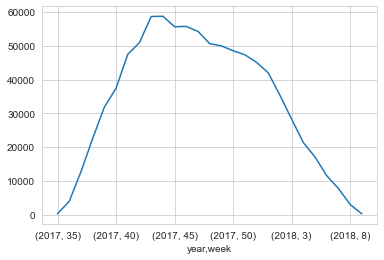

In [48]:
df_group_by_year_week['count'].plot()

Despite the decrease, we want to see if anything has improved over time.<br>
The column of the average total views for the unique videos in that week shows that there has been an increase at the beginning and at the end of the analysis period.

<AxesSubplot:xlabel='year,week'>

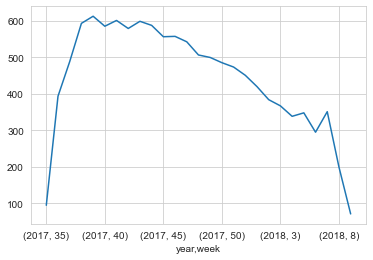

In [49]:
df_group_by_year_week['mean_views_for_video'].plot()

We can see it also in the percent change of the average total views for the unique videos in that week compared to the previous week

<AxesSubplot:xlabel='year,week'>

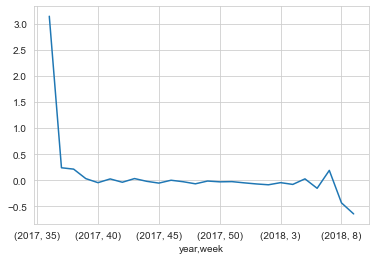

In [50]:
df_group_by_year_week['mean_views_for_video_pct_change'].plot()

Next, let's look at the video's characteristics which caused positive percent changes during the weeks.

In the top positive periods, Spanish was one of the most common languages.<br>
It's important to keep in mind that the first period (36) does not count as the increase from the company's first week, and the following is due to the novelty effect.<br>
But in week 7 of 2018, we can see that Spanish was the most viewed video language and percent was positive as well.<br>
In addition, we do not have a week where Spanish was among the top 3 languages with a negative percentage.<br>
From that conclusion, we can assume that Spanish has a positive effect on the views of the videos.

In [51]:
df_group_by_year_week['mean_views_for_video_pct_change'] = df_group_by_year_week['mean_views_for_video'].pct_change()
df_group_by_year_week.sort_values('mean_views_for_video_pct_change',ascending=False).head(9)

video_id_count  video_rows_count  count  video_length  \
year week                                                          
2017 36                10                38   3934     21.815789   
     37                26               127  12690     21.771654   
     38                38               222  22525     21.797297   
2018 7                 22               133   7724     22.887218   
2017 43                98               655  58639     22.638168   
     39                52               317  31835     22.104101   
2018 5                 49               313  17046     23.047923   
2017 41                79               507  47457     22.623274   
     46               100               691  55716     22.746744   

                 video_quality       video_language  mean_views_for_video  \
year week                                                                   
2017 36     [480p, 720p, 240p]   [english, spanish]            393.400000   
     37    [480p, 360p, 1080p]   [spanish, english]            488.076923   
     38    [480p, 1080p, 360p]  [spanish, chineese]            592.763158   
2018 7     [360p, 480p, 1080p]  [spanish, chineese]            351.090909   
2017 43     [480p, 360p, 720p]  [chineese, english]            598.357143   
     39    [480p, 1080p, 360p]  [chineese, english]            612.211538   
2018 5      [360p, 480p, 240p]  [chineese, spanish]            347.877551   
2017 41     [480p, 360p, 240p]  [chineese, english]            600.721519   
     46     [480p, 360p, 720p]  [chineese, english]            557.160000   

           mean_views_for_video_pct_change  
year week                                   
2017 36                           3.141053  
     37                           0.240663  
     38                           0.214487  
2018 7                            0.190449  
2017 43                           0.033878  
     39                           0.032810  
2018 5                            0.028065  
2017 41                           0.027121  
     46                           0.001816

But it is hard to say it for 100% percent sure because if we will look at the top watched videos overall, Spanish was not among them. <br>
It is just worth to mention that Spanish have the potential to cause a positive effect on the users.

In [52]:
df_group_by_year_week.sort_values('count',ascending=False).head()

video_id_count  video_rows_count  count  video_length  \
year week                                                          
2017 44               100               685  58724     22.670073   
     43                98               655  58639     22.638168   
     46               100               691  55716     22.746744   
     45               100               682  55615     22.760997   
     47               100               693  54228     22.721501   

                video_quality       video_language  mean_views_for_video  \
year week                                                                  
2017 44    [480p, 360p, 720p]  [chineese, english]            587.240000   
     43    [480p, 360p, 720p]  [chineese, english]            598.357143   
     46    [480p, 360p, 720p]  [chineese, english]            557.160000   
     45    [480p, 360p, 720p]  [chineese, english]            556.150000   
     47    [480p, 360p, 720p]  [chineese, english]            542.280000   

           mean_views_for_video_pct_change  
year week                                   
2017 44                          -0.018579  
     43                           0.033878  
     46                           0.001816  
     45                          -0.052943  
     47                          -0.026707

### Quick summary of what we have until now:

<ol>
  <li>
      Short videos are more popular.
  </li>
    <li>
        Higher Quality is more popular.
    </li>
        <li>
        English and Chinese are more popular (and Spanish might have a positive effect on the viewers).
    </li>
    
</ol>



### Using an Unsupervised Algorithm to cluster the videos
As we do not know in advance which video belongs to the Top, Good, or Else categories, we will use an Unsupervised Algorithm to verify our assumptions and conclusions throughout the analysis.

In [53]:
df_cluster = df.groupby('video_id').agg({        
        'count':'sum',
        'video_length':'mean',
        'video_language':lambda x: x.value_counts().index[0],
        'video_quality':lambda x: x.value_counts().index[0]
})

In [54]:
df_cluster.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 1 to 100
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   count           100 non-null    int64  
 1   video_length    100 non-null    float64
 2   video_language  100 non-null    object 
 3   video_quality   100 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.9+ KB


In [55]:
categorical_columns = [i for i in range(len(np.array(df_cluster.dtypes))) if np.array(df_cluster.dtypes)[i]!=np.dtype('float64') and np.array(df_cluster.dtypes)[i]!=np.dtype('int64')] 

In [56]:
cost = []
for num_clusters in list(range(1,10)):
    kproto = KPrototypes(n_jobs = -1, n_clusters = num_clusters, init = 'Cao',verbose=1,max_iter=100,n_init=10)
    kproto.fit_predict(df_cluster, categorical=categorical_columns)
    cost.append(kproto.cost_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 6
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 2
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 10
Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 3


The elbow method shows that in 3 clusters, we get the proportion between minimizing the error (cost) and the clustering number (even though we know our target is 3).

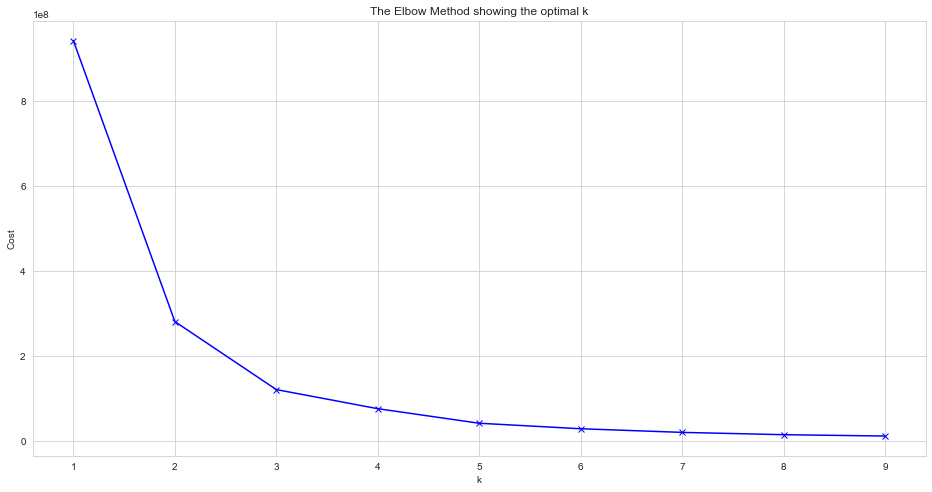

In [57]:
plt.figure(figsize=(16,8))
plt.xlabel('k')
plt.ylabel('Cost')
plt.title('The Elbow Method showing the optimal k')
plt.plot(list(range(1,10)), cost, 'bx-')

In [58]:
kproto = KPrototypes(n_jobs = -1, n_clusters = 3, init = 'Cao',verbose=1,max_iter=100,n_init=10)
clusters = kproto.fit_predict(df_cluster, categorical=categorical_columns)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Best run was number 1


Our assumptions have been confirmed. Among the top videos, there were an average of 12.5K views the most compared to the other videos, they lasted for a short period of time, were mostly in English, and were in 720p quality.

In [59]:
print(kproto.cluster_centroids_)

[['8805.081081081082' '22.89189189189189' 'spanish' '360p']
 ['5296.733333333334' '27.966666666666665' 'chineese' '480p']
 ['12518.939393939394' '17.696969696969695' 'english' '720p']]


In [60]:
df_cluster['clusters'] = clusters

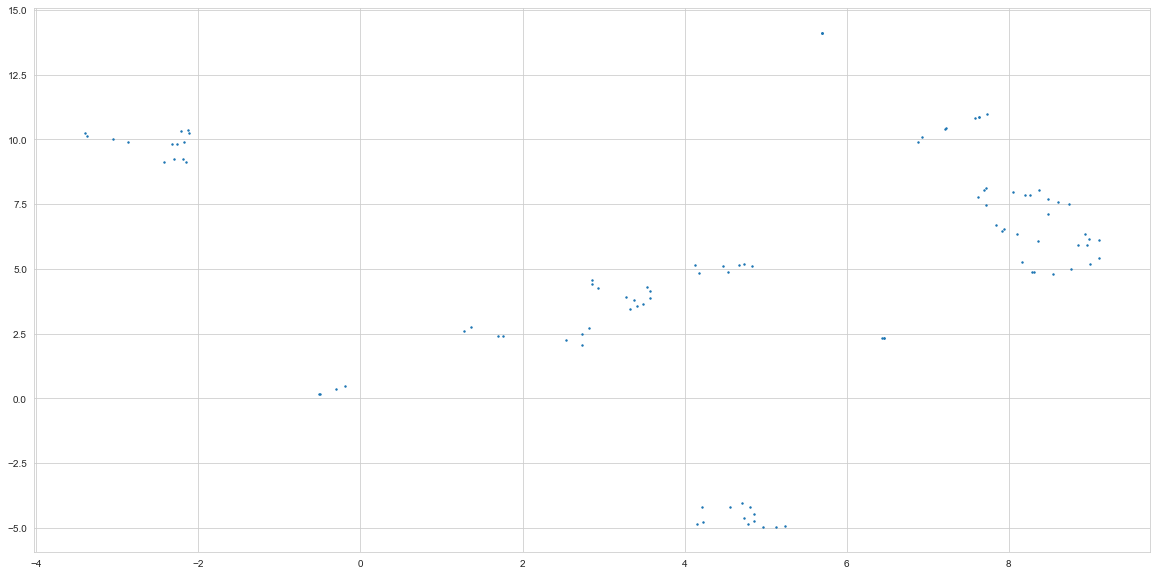

In [61]:
#Preprocessing numerical
numerical = df_cluster.select_dtypes(exclude =['bool','object'])

##preprocessing categorical
categorical = df_cluster.select_dtypes(include=['object','bool'])
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(df_cluster.select_dtypes(include='object').columns) / df_cluster.shape[1]

#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)


#Augmenting the numerical embedding with categorical
intersection = umap.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.reset_local_connectivity(intersection)

embedding = umap.simplicial_set_embedding(data=fit1._raw_data,graph=intersection,n_components=fit1.n_components,initial_alpha=fit1._initial_alpha,a=fit1._a,b=fit1._b,gamma=fit1.repulsion_strength,n_epochs=200,init='random',random_state=np.random,metric=fit1.metric,densmap=False,negative_sample_rate=fit1.negative_sample_rate,densmap_kwds=fit1._metric_kwds,metric_kwds=fit1.metric_kwds,output_dens=fit1.output_dens)
embedding1=embedding[0]

plt.figure(figsize=(20, 10))
plt.scatter(*embedding1.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

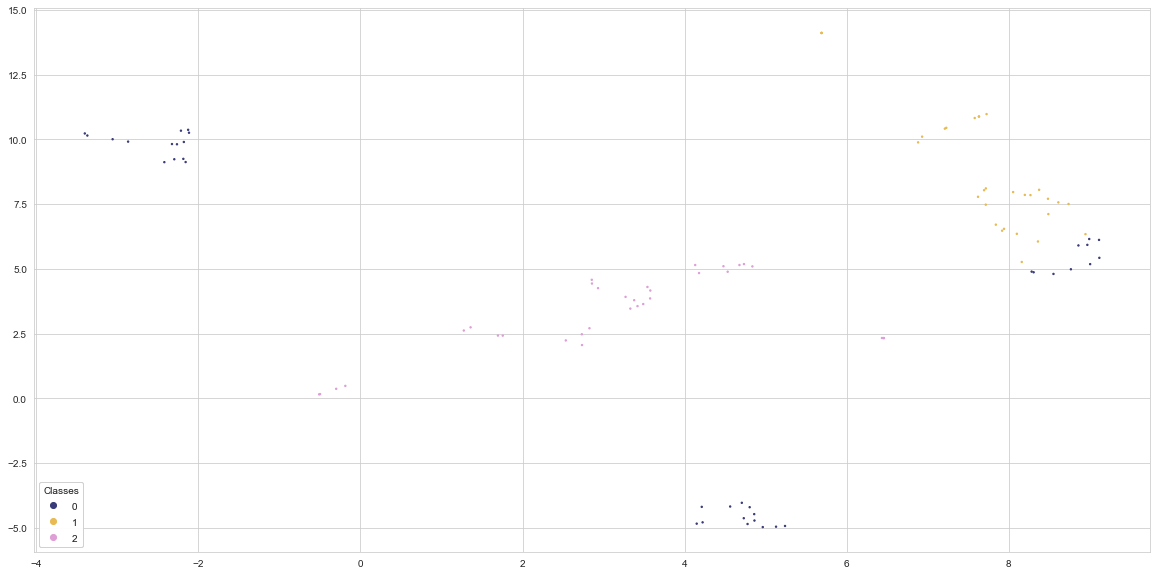

In [62]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding1[:, 0], embedding1[:, 1], s=2, c=clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=2),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [67]:
df_cluster.replace({'clusters':{0:'else',1:'top',2:'good'}},inplace=True)

This table summarizes the characteristics of each cluster (top, good, else).

In [68]:
df_cluster.reset_index().groupby('clusters').agg({
    'video_id':'count',
    'count':'mean',
    'video_length':'mean',
    'video_language':lambda x: x.value_counts().index[0],
    'video_quality':lambda x: x.value_counts().index[0:2]
    
})

,video_id,count,video_length,video_language,video_quality
clusters,,,,,
else,30,5296.733333,27.966667,chineese,"[480p, 240p]"
good,33,12518.939394,17.696970,english,"[720p, 1080p]"
top,37,8805.081081,22.891892,spanish,"[360p, 480p]"


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 0, ncost: 942030475.2494999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 23, ncost: 296265819.8470578
Run: 10, iteration: 2/100, moves: 10, ncost: 281599669.7852548
Run: 10, iteration: 3/100, moves: 2, ncost: 280730651.71258557
Run: 10, iteration: 4/100, moves: 0, ncost: 280730651.71258557
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 4, iteration: 1/100, moves: 1, ncost: 124605877.86055334
Run: 4, iteration: 2/100, moves: 0, ncost: 124605877.86055334
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 11, ncost: 123264183.96278308
Run: 9, iteration: 2/100, moves: 5, ncost: 121070971.7932397
Run: 9, iteration: 3/100, moves: 2, ncost: 120576102.881602
Run: 9, iteration: 4/100, moves: 0, ncost: 120576102.881602

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 0, ncost: 942030475.2494999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 10, iteration: 1/100, moves: 0, ncost: 942030475.2494999
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9, iteration: 1/100, moves: 15, ncost: 296265819.8470578
Run: 9, iteration: 2/100, moves: 10, ncost: 281599669.7852548
Run: 9, iteration: 3/100, moves: 2, ncost: 280730651.71258557
Run: 9, iteration: 4/100, moves: 0, ncost: 280730651.71258557
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 19, ncost: 136089949.7016402
Run: 2, iteration: 2/100, moves: 9, ncost: 122710132.00455219
Run: 2, iteration: 3/100, moves: 4, ncost: 120576102.881602
Run: 2, iteration: 4/100, moves: 0, ncost: 120576102.881602
Init: initializing centroids
Init: initializing clusters
Starting